In [32]:
import os
import cv2
import glob
import xml.etree.ElementTree as ET
import numpy

xml_datoteka = 'unprocessed/oznake_20250328_091617.xml'
video_datoteka = 'unprocessed/posnetek_20250328_091617.mp4'
frame_shrani = 'tmp/slike'
anotacija_shrani = 'tmp/oznake'

files = glob.glob(f'{frame_shrani}/*')
for f in files:
    os.remove(f)
files = glob.glob(f'{anotacija_shrani}/*')
for f in files:
    os.remove(f)

capture = cv2.VideoCapture(video_datoteka)
stevilka_slike = 1

while(True):
    success, frame = capture.read()
    if success:
        cv2.imwrite(f'{frame_shrani}/{stevilka_slike}.png', frame)
        with open(f'{anotacija_shrani}/{stevilka_slike}.txt', 'w') as fp:
            pass
    else:
        break
    stevilka_slike+=1
capture.release()

tree = ET.parse(xml_datoteka)
root = tree.getroot()
img_width = int(root[1][2][0].text)
img_height = int(root[1][2][1].text)

for branch in root:
    if(branch.tag == 'track'):
        for polygon in branch:
            if polygon.attrib['outside'] == '0':
                #print(polygon.attrib['frame'])
                obj_type = branch.attrib['label']
                obj_blizina = polygon[0].text
                objekt = f'{obj_type}-{obj_blizina}'
                objekt_st = 0
                if(obj_type == 'vozila'):
                    objekt_st+=3
                elif(obj_type == 'ostalo'):
                    objekt_st+=6
                if(obj_blizina == 'blizu'):
                    objekt_st+=1
                elif(obj_blizina == 'dalec'):
                    objekt_st+=2

                polygon_points_str = polygon.attrib['points']
                points = [tuple(map(float, point.split(','))) for point in polygon_points_str.strip().split(';')]
                xs = [pt[0] for pt in points]
                ys = [pt[1] for pt in points]
                min_x = min(xs)
                max_x = max(xs)
                min_y = min(ys)
                max_y = max(ys)

                obj_class = objekt_st 
                x_center = (min_x + max_x) / 2.0 / img_width
                y_center = (min_y + max_y) / 2.0 / img_height
                obj_width = (max_x - min_x) / img_width
                obj_height = (max_y - min_y) / img_height
                frame = int(polygon.attrib['frame']) + 1
                with open(f'{anotacija_shrani}/{frame}.txt', "a") as f:
                    f.write(f"{obj_class} {x_center:.6f} {y_center:.6f} {obj_width:.6f} {obj_height:.6f}\n")                
                
                #with open("demofile.txt", "a") as f:
                #    f.write("Now the file has more content!")

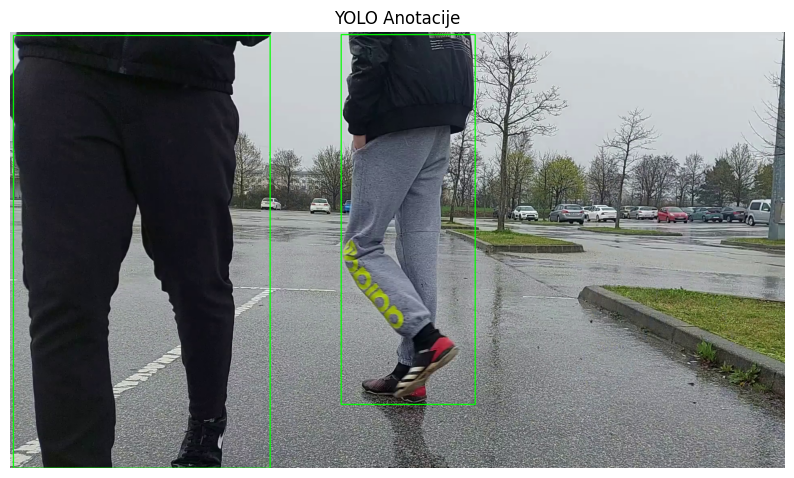

In [41]:
import cv2
import matplotlib.pyplot as plt

frame = 6

image_path = f'tmp/slike/{frame}.png'
annotation_path = f'tmp/oznake/{frame}.txt'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_h, img_w = image.shape[:2]

with open(annotation_path, 'r') as file:
    lines = file.readlines()

for line in lines:
    parts = line.strip().split()
    class_id = int(parts[0])
    x_center, y_center, bbox_w, bbox_h = map(float, parts[1:5])

    x_min = int((x_center - bbox_w / 2) * img_w)
    x_max = int((x_center + bbox_w / 2) * img_w)
    y_min = int((y_center - bbox_h / 2) * img_h)
    y_max = int((y_center + bbox_h / 2) * img_h)

    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color=(0, 255, 0), thickness=2)
    cv2.putText(image, f'class {class_id}', (x_min, y_min - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.axis('off')
plt.title("YOLO Anotacije")
plt.show()
